In [224]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import glob
from scipy.misc import imread


from keras.preprocessing import image
from keras.models import load_model

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [225]:
DATA_PATH = '/a/data/fisheries_monitoring/data/'
INPUT_WIDTH = 224
INPUT_HEIGHT = 224

In [240]:
def load_test_data():
    X_test_raw = []
    id_test = []
    file_path = glob.glob(DATA_PATH + 'test_stg1/*.jpg')
    for path in file_path:                          
        img = imread(path)
        file_name = os.path.basename(path)
        X_test_raw.append(img)
        id_test.append(file_name)
    return X_test_raw, np.array(id_test)


def load_test_data(INPUT_WIDTH, INPUT_HEIGHT):
    X_test_raw = []
    X_test = []
    id_test = []
    path = glob.glob(DATA_PATH + 'test_stg1/*.jpg')
    for i in xrange(len(path)):
        img_raw = image.load_img(path[i])
        img = img_raw
        img_raw = image.img_to_array(img)
        img_raw /= 255

        img = img.resize((INPUT_WIDTH, INPUT_HEIGHT))
        img = image.img_to_array(img)
        img /= 255

        X_test_raw.append(img_raw)
        X_test.append(img)        
        id_test.append(os.path.basename(path[i]))
        
        if (i+1) in [k*len(path)/5 for k in xrange(1,6)]:
                print "Loading...{}% done!".format((i+2)*100/len(path))
    return X_test_raw, np.array(X_test), np.array(id_test)


def visualize_prediction(img, index = None, true_box = None, pred_box = None, ax = None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.imshow(img)
    if index is not None:
        ax.set_title(index)
    height = img.shape[0]
    width = img.shape[1]
    
    if true_box is not None:
        x, y, w, h = true_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='\\',
            fill=False,      # remove background
            color = 'r',
            linewidth = 2.5
                )
            )
    if pred_box is not None:
        x, y, w, h = pred_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='-',
            fill=False,      # remove background
            color = 'k',
            linewidth = 2.5
                )
            )

def make_plot(data, nrow = 2, ncol = 2, index = None, true_box = None, pred_box = None, figsize = (15,8)):
    # Create grid
    _, ax = plt.subplots(nrow, ncol, figsize=figsize)
    
    idx = None
    tbox = None
    pbox = None
    # Generate indices of images to show
    for axi in np.ravel(ax):
        n = np.random.choice(len(data))
        img = data[n]
        if index is not None:
            idx = index[n]
        if true_box is not None:
            tbox = true_box[n]
        if pred_box is not None:
            pbox = pred_box[n]
        
        # Visualize it along with the box
        visualize_prediction(img, index = idx, true_box = tbox, pred_box = pbox, ax = axi)


# Crop all the fishes and save them as separate files.
def crop_all_fishes(id_test, y_pred):
    X_crop = []
    for i in xrange(len(id_test)):
        file_name = DATA_PATH + 'test_stg1/' + id_test[i]
        img = Image.open(file_name)
        
        width, height = img.size
        x, y, w, h = y_pred[i]
        left = int(max(x,0) * width)
        right = int(min((x + w), 1) * width)
        top = int(max(y,0) * height)
        bottom = int(min((y + h), 1) * height)
        img = img.crop((left, top, right, bottom))
        img = img.resize((224,224))
        img = image.img_to_array(img)
        img /= 255
        X_crop.append(img)
        if (i+1) in [k*len(id_test)/5 for k in xrange(1,6)]:
            print "Cropping fishes...{}% done!".format((i+2)*100/len(id_test))
    return np.array(X_crop)

def make_submission(id_test, y_pred):
    df1 = pd.DataFrame(id_test, columns = ["image"])
    df2 = pd.DataFrame(y_pred, columns = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'NoF'])
    df2_reorder = df2.reindex_axis(sorted(df2.columns), axis=1)
    submission = pd.concat([df1,df2_reorder],axis = 1)
    submission = submission.sort_values(by = "image")
    submission.to_csv(DATA_PATH + 'submission.csv', header = True, index = False)
    return submission

## Load test data

In [227]:
X_test_raw, X_test, id_test = load_test_data(INPUT_WIDTH, INPUT_HEIGHT)
print "Length of raw test data:", len(X_test_raw)
print "Shape of X_test:", X_test.shape
print "Shape of id_text:", id_test.shape

Loading...20% done!
Loading...40% done!
Loading...60% done!
Loading...80% done!
Loading...100% done!
Length of raw test data: 1000
Shape of X_test: (1000, 224, 224, 3)
Shape of id_text: (1000,)


## Visualize some test examples

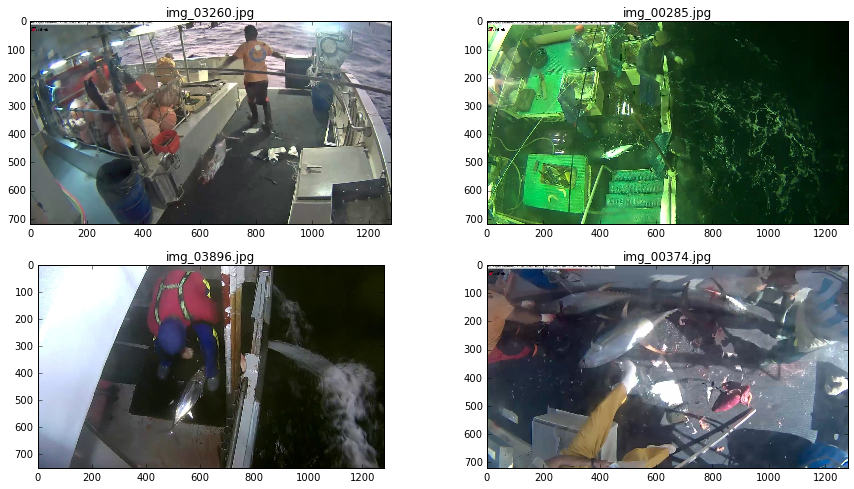

In [208]:
make_plot(data = X_test_raw, nrow = 2, ncol = 2, index = id_test, true_box = None, pred_box = None)

## Load pretrained models

In [136]:
localizer = load_model(DATA_PATH + 'models/localizers/ResNet50_SuperBox.h5')
classifier = load_model(DATA_PATH + 'models/classifiers/ResNet50_SuperBox.h5')

## Predict bounding boxes by localizer

In [228]:
pred_box = localizer.predict(X_test.astype('float32'), verbose = 1)

1000/1000 [==============================] - 11s     

## Visualize bounding box predictions

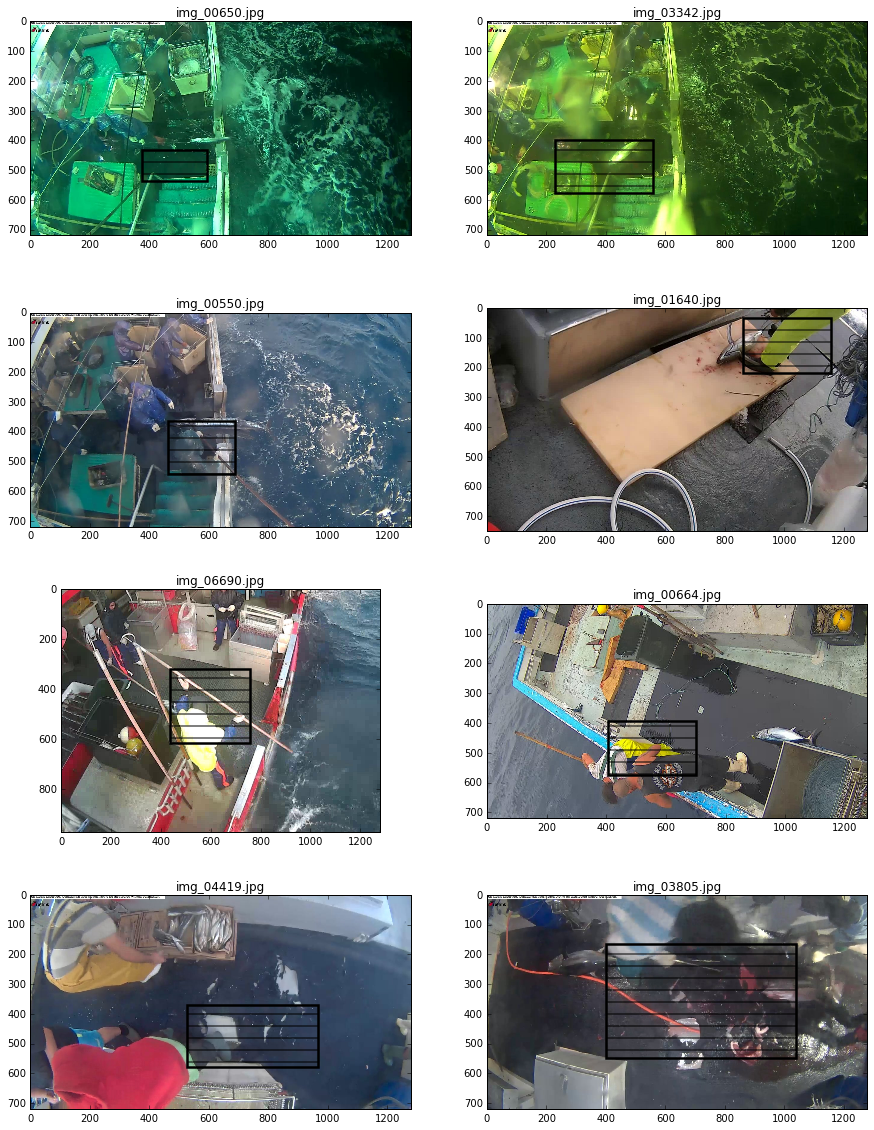

In [229]:
make_plot(data = X_test_raw, nrow = 4, ncol = 2, index = id_test, pred_box = pred_box, figsize = (15,20))

In [241]:
X_crop = crop_all_fishes(id_test, pred_box)

Cropping fishes...20% done!
Cropping fishes...40% done!
Cropping fishes...60% done!
Cropping fishes...80% done!
Cropping fishes...100% done!


## Predict classes by classifier

In [242]:
y_pred = classifier.predict(X_crop.astype('float32'), verbose=1)

1000/1000 [==============================] - 12s     

## Make submission

In [243]:
submission = make_submission(id_test, y_pred)

In [244]:
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
20,img_00005.jpg,0.580331,0.001991,0.002980,0.000071,0.382160,0.021598,0.005006,0.005864
262,img_00007.jpg,0.497283,0.019639,0.008016,0.000522,0.012867,0.025579,0.000638,0.435457
146,img_00009.jpg,0.740527,0.004231,0.005526,0.000040,0.000061,0.249329,0.000097,0.000189
175,img_00018.jpg,0.139784,0.007484,0.000524,0.000147,0.000163,0.850428,0.000028,0.001441
137,img_00027.jpg,0.032573,0.029843,0.000068,0.003048,0.000194,0.010589,0.000224,0.923462
